In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from geopy.geocoders import Nominatim
#from translate import Translator
import seaborn as sns
#from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

Using TensorFlow backend.


In [2]:
root_path = "/Users/vivian/Desktop/Furiends/Furiends/data/raw/Fake Data2"

In [3]:
# View all the files in the data folder; 
os.listdir(root_path)

['whole11.csv',
 'fulldb-09-03-2023-23-04-beta.sql',
 'frequency&duration_activity.csv',
 'bigT2.csv',
 'bigT3.csv',
 'data_with_satisfication.csv',
 'freq&dura per user per act_category.sql',
 'bigT.sql']

## Data Loading

In [4]:
data = pd.read_csv(os.path.join(root_path, 'data_with_satisfication.csv')).drop(["Unnamed: 0"], axis=1)
data

,User_id,First_Name,Last_Name,Address,Age,Gender,Rehabilitation,Pet_intimacy,category_name,Pet_Name,log_count,com_count,avg_loading,sum_duration,Zipcode,Country,Country_abbrev,Continent,User_satisfication
0,1,Jane,Bruen,"5272 Adela Overpass Suite 982\nRozellachester,...",28,1,2,0.414141,'Maltese',Barney,0.333333,0.333333,0.526948,0.268787,14374,United States,US,NaN,3.516239
1,2,Eliseo,Trantow,"2506 Mertz Inlet\nSouth Ezekielshire, OK 56215",12,1,1,0.111111,'Golden Retriever',Juliana,0.000000,0.083333,1.000000,0.003579,56215,South Korea,KR,AS,3.708759
2,3,Oceane,Walter,"9469 Frank Orchard Apt. 685\nLake Irmastad, ID...",64,1,2,0.909091,'Bulldog',Sabrina,0.500000,0.166667,0.526618,0.225447,72714,United States,US,NaN,4.004165
3,4,Zack,Marvin,"982 Susan Manors\nPort Amiya, UT 97043-2723",38,1,1,0.858586,'German Shepherd',Yasmine,0.666667,0.583333,0.550415,0.831412,97043,Ukraine,UA,EU,9.151314
4,5,Marco,Kessler,"671 Troy Isle Suite 459\nNew Carriemouth, OK 6...",28,1,1,0.181818,'German Shepherd',Cristopher,0.250000,0.500000,0.821139,0.045328,61216,South Korea,KR,AS,4.684270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,596,Ethan,Schuppe,"17224 Koelpin Rest\nTheresiashire, GA 69914",79,2,1,0.818182,'Bulldog',Filomena,0.250000,0.333333,0.396222,0.306561,69914,Brazil,BR,SA,5.773980
571,597,Austin,Legros,"476 Veda View\nGroverfurt, AK 15766-2282",80,1,2,0.909091,'Shi-ba-inu',Herta,0.166667,0.500000,0.425255,0.201590,15766,Brazil,BR,SA,3.474042
572,598,Ilene,Dietrich,"934 Josianne Inlet\nLavonnechester, AZ 30057-6787",74,1,2,0.272727,'Poodle',Lamont,0.083333,0.333333,0.215269,0.004374,30057,Taiwan,TW,AS,1.505491
573,599,Novella,Becker,"76281 Germaine Valley\nBoscobury, DE 99069-3814",29,2,2,0.090909,'Golden Retriever',Wendy,0.500000,0.166667,0.427905,0.757455,99069,United States,US,NaN,5.215302


In [5]:
data["User_satisfication"].describe()

count    575.000000
mean       4.772740
std        1.406016
min        1.296136
25%        3.776412
50%        4.841757
75%        5.711057
max        9.151314
Name: User_satisfication, dtype: float64

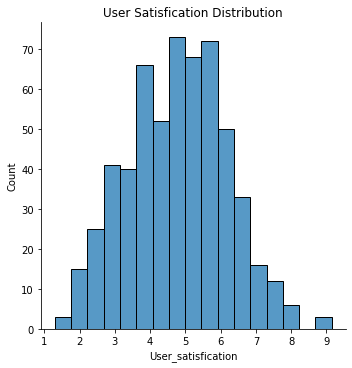

In [6]:
sns.displot(data, x="User_satisfication").set(title="User Satisfication Distribution")

In [7]:
data.shape

(575, 19)

In [8]:
data["category_name"] = data["category_name"].replace({"'Bulldog'": 1,
                                                      "'Maltese'": 2,
                                                      "'Poodle'": 3,
                                                      "'German Shepherd'": 4,
                                                      "'Golden Retriever'": 5,
                                                      "'Shi-ba-inu'": 6})


In [9]:
X = data[["Age", "Gender", "Rehabilitation", "Pet_intimacy", "log_count", "com_count", "avg_loading", "category_name", "sum_duration"]].values
Y = data[["User_satisfication"]].values

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_normal = preprocessing.normalize(X_scale)
X_normal

array([[0.15181218, 0.        , 0.74008437, ..., 0.38998629, 0.14801687,
        0.19892526],
       [0.        , 0.        , 0.        , ..., 0.77631354, 0.62105083,
        0.00277806],
       [0.39305406, 0.        , 0.58958109, ..., 0.310484  , 0.        ,
        0.13291947],
       ...,
       [0.55780589, 0.        , 0.7017558 , ..., 0.15106637, 0.28070232,
        0.00306931],
       [0.11284374, 0.51775365, 0.51775365, ..., 0.22154939, 0.41420292,
        0.39217523],
       [0.11525639, 0.        , 0.69153831, ..., 0.26162144, 0.13830766,
        0.20044987]])

In [11]:
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X_normal, Y, test_size=0.3)

In [12]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test_val, Y_test_val, test_size=0.5)

In [13]:
print("Train size: ", X_train.shape[0], "\nValidation size: ", X_val.shape[0], "\nTest size: ", X_test.shape[0])

Train size:  402 
Validation size:  86 
Test size:  87


In [15]:
# There are 9 columns in the X data, meaning we are using 8 features to make predictions
# We would build a neural network with two hidden layers of size 32 and output a single predicted value of y(the satisfication level)
# website to draw nn archetecture: http://alexlenail.me/NN-SVG/index.html
nn_model = Sequential([
    Dense(32, activation="relu", input_shape=(9,)),
    Dense(32, activation="relu"),
    Dense(1, activation="linear"),
])

nn_model.compile(optimizer='adam',
                loss="mse",
                metrics=['mean_squared_error'])
Y_pred = nn_model.fit(X_train, Y_train, batch_size=70, epochs=150, verbose=0,validation_data=(X_val, Y_val))

In [16]:
score = nn_model.evaluate(X_test, Y_test, verbose=0)

Since feature importance is commonly determined by tree-based model, we directly use gradient boosting to find out feature importance.

([<matplotlib.axis.XTick at 0x7fe8606e63c8>,
 [Text(0, 0, 'Age'),
  Text(1, 0, 'Gender'),
  Text(2, 0, 'Rehabilitation'),
  Text(3, 0, 'Pet_intimacy'),
  Text(4, 0, 'log_count'),
  Text(5, 0, 'com_count'),
  Text(6, 0, 'avg_loading'),
  Text(7, 0, 'category_name'),
  Text(8, 0, 'sum_duration')])

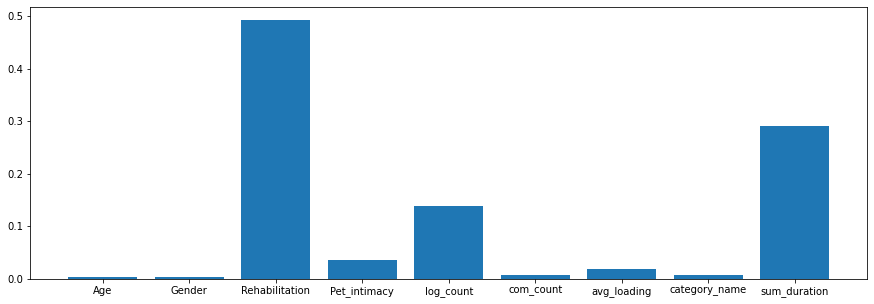

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

nn = GradientBoostingRegressor(n_estimators=100)
nn.fit(X_val, Y_val.ravel())
plt.figure(figsize=(15, 5))
plt.bar(range(X_val.shape[1]), nn.feature_importances_)
plt.xticks(range(X_val.shape[1]), ["Age", "Gender", "Rehabilitation", "Pet_intimacy", "log_count", "com_count", "avg_loading", "category_name", "sum_duration"])

# == Above are the code for Neural Network, below were previously wrote ==

In [ ]:
# Neural Network
class NN():
    def __init__(self, input_n, layers=[256,128], output_n, lr, iterations):
        self.input_layer = input_n
        self.output_layer = output_n
        self.fc1 = nn.Linear(self.input_layer, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], self.output_layer)

        self.lr = lr
        self.iterations = iterations
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class NN_train_test():
    def __init__(self, input_n, layers, output_n, lr， iterations, num_epochs):
        self.model = NN(input_n=input_n, layers=layers, output_n=output_n, lr=lr, iterations=iterations)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(),lr=lr)
        self.num_epochs = num_epochs
    def train(X, y):
        for epoch in range(self.num_epochs):
            correct = 0
            l = 0
            for i in range(X.shape[0]):
                data = X.iloc[i, :]
                result = y.iloc[i, :]
                prediction = self.model(data)
                loss = self.criterion(prediction, result)
                loss.backward()
                optimizer.step()

                _, predictions = prediction.max(dim=1)
                correct += torch.eq(predictions, result).sum().item()
                l += result.shape[0]
            accuracy = correct / l
            print("Epoch: {}, Accuracy: {}".format(epoch, accuracy))

    def test(X, y):
        pass

In [ ]:
# Logistic Model
input = data.loc[:, 'Have diseases':"Recovery"]
target = data[["Recovery"]]

X, y = input, target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [ ]:
iterations_n = 1000
learning_rate = 0.01
num_feature = len(cols)

In [ ]:
class PytorchLRModel(nn.Module):
    def __init__(self, num_feature):
        super(PytorchLRModel, self).__init__()
        self.fc1 = nn.Linear(num_feature, 2)
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x[:,1]

clf = PytorchLRModel(num_feature)
criterion = nn.BCELoss()

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(clf.parameters(), lr=learning_rate)
input = Variable(torch.Tensor(X_train.values))
target = Variable(torch.Tensor(y_train.values)).long()

clf.train()
for iter_ in range(iterations_n):
  optimizer.zero_grad()
  scores = clf(input)
  loss = criterion(scores.unsqueeze(1), target.float())
  loss.backward()
  optimizer.step()

  if iter_ % 100 == 0:
    print('Iteration {}, Loss: {}'.format(iter_, loss.data.cpu().numpy()))

In [ ]:
clf.eval()
target = Variable(torch.Tensor(y_test.values)).long()
y_hat = clf(Variable(torch.Tensor(X_test.values)))
predictions = (y_hat >= 0.5).float()
print(predictions)
print(target.shape)
accuracy = torch.eq(predictions, target).sum().item() / target.size()[0]
print("Accuracy: ", accuracy)

In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 8, random_state = 18).fit(X_train, y_train)
prediction = rf.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)

In [ ]:
# Neural Network
class NN():
    def __init__(self, input_n, layers=[256,128], output_n, lr, iterations):
        self.input_layer = input_n
        self.output_layer = output_n
        self.fc1 = nn.Linear(self.input_layer, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], self.output_layer)

        self.lr = lr
        self.iterations = iterations
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class NN_train_test():
    def __init__(self, input_n, layers, output_n, lr， iterations, num_epochs):
        self.model = NN(input_n=input_n, layers=layers, output_n=output_n, lr=lr, iterations=iterations)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(),lr=lr)
        self.num_epochs = num_epochs
    def train(X, y):
        for epoch in range(self.num_epochs):
            correct = 0
            l = 0
            for i in range(X.shape[0]):
                data = X.iloc[i, :]
                result = y.iloc[i, :]
                prediction = self.model(data)
                loss = self.criterion(prediction, result)
                loss.backward()
                optimizer.step()

                _, predictions = prediction.max(dim=1)
                correct += torch.eq(predictions, result).sum().item()
                l += result.shape[0]
            accuracy = correct / l
            print("Epoch: {}, Accuracy: {}".format(epoch, accuracy))

    def test(X, y):
        pass

In [ ]:
# RNN
